<a href="https://colab.research.google.com/github/jajapuramshivasai/projects_24/blob/main/Model_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'tig-aluminium-5083:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F63362%2F123140%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240720%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240720T011614Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D5367b5f599cdaee8956afcb1b7d7661d78f41957a93082feb04b7dce0341960679a04ed6390a4f70995fc69ccc45aa26fa70b4ba2b195ccf9729e7032726eb38c3bfc61e129d770fc3cea3bba9620290339cc361da32fec5cb397ec7c54f96620b621322986af20a81d6c0c3c21c5de1889e5c98d7b6147c3e33fd742ab7779bb696b6d359add1f1811574fe4a34d58b5d4f9b33a0495cc56eecdd7293e0fa4ae52519c8864637c3bcad4a51e967a1a159698744258a994b34f2ca62e391bbf72dec1db3193a780b23db87870d76b77aea166911f050bb3265195458cdfa1dff9839833235d61f0ffa9ad84dedb5bd1120daf48c5d9a24fbd1c4abbffcb36a36'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 12018590658 bytes downloaded
Downloaded and uncompressed: tig-aluminium-5083
Data source import complete.


In [2]:
#importing necessary libraries
import tensorflow as tf
from tensorflow.keras import layers, models
import json
import os
from PIL import Image
import random
import numpy as np
import matplotlib.pyplot as plt

In [5]:
!pip install silence-tensorflow

from silence_tensorflow import silence_tensorflow
silence_tensorflow()

  Preparing metadata (setup.py) ... done
  Created wheel for silence-tensorflow: filename=silence_tensorflow-1.2.2-py3-none-any.whl size=5829 sha256=309d79923ecd9e30a6c1f521e38afeef824ff5d24292466e75f32ba3b0c1950b
  Stored in directory: /root/.cache/pip/wheels/4e/e1/85/e501d21f8d79832caa65e1b779bc17d1847ebc0170f7bc5a80
Successfully built silence-tensorflow


In [3]:
train_json = '/kaggle/input/tig-aluminium-5083/al5083/train/train.json'

with open(train_json, 'r') as json_file:
    train_data_json = json.load(json_file)

In [4]:
label_names = ["good weld", "burn through", "contamination", "lack of fusion", "misalignment", "lack of penetration"]
labels = [0, 1, 2, 3, 4, 5]
one_hot_encoding = tf.keras.utils.to_categorical(labels, num_classes=6)
label_count = [0, 0, 0, 0, 0, 0]

In [5]:
for l in train_data_json:
    label_count[train_data_json[l]] += 1

label_count

[8758, 1783, 6325, 4028, 2953, 2819]

In [6]:
all_data = []
image_size = (256, 256)
label_count = [0, 0, 0, 0, 0, 0]

In [7]:
def load_data(path):
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if(os.path.isdir(folder_path)):
            for img_name in os.listdir(folder_path):

                img_path = os.path.join(folder_path, img_name)
                key_name = folder + '/' + img_name
                label = train_data_json[key_name]

                if(label_count[label] > 2000):
                    continue

                label_count[label] += 1
                image = Image.open(img_path).resize(image_size)
                image = tf.convert_to_tensor(image)
                all_data.append((image, one_hot_encoding[label]))

                if(len(all_data)%100==0):
                    print(f"Total images loaded : {len(all_data)}, Label count : {label_count}", end = '\r')

In [8]:
load_data('/kaggle/input/tig-aluminium-5083/al5083/train')

In [9]:
X = []
y = []

for data in all_data:
    X.append(data[0])
    y.append(data[1])

In [10]:
np.random.seed(42)
rand_num = np.random.randint(low = 0, high = len(all_data))
X[rand_num], y[rand_num]

(<tf.Tensor: shape=(256, 256), dtype=uint8, numpy=
 array([[10, 11, 11, ..., 10, 11, 11],
        [10, 11, 11, ..., 10, 11, 11],
        [11, 12, 12, ..., 11, 12, 12],
        ...,
        [26, 25, 27, ..., 51, 49, 49],
        [27, 26, 26, ..., 51, 50, 50],
        [26, 26, 26, ..., 47, 47, 47]], dtype=uint8)>,
 array([0., 0., 0., 0., 1., 0.], dtype=float32))

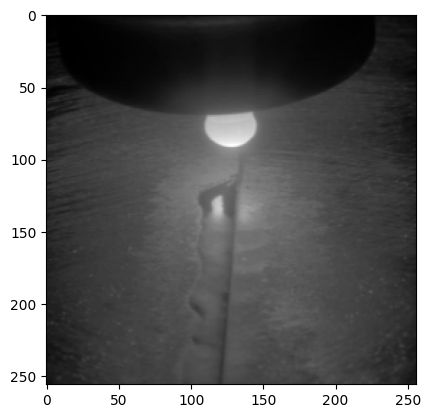

Label : lack of fusion


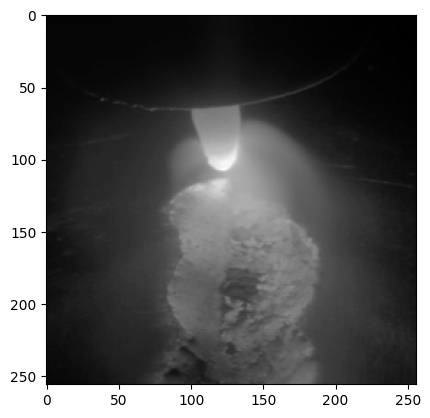

Label : contamination


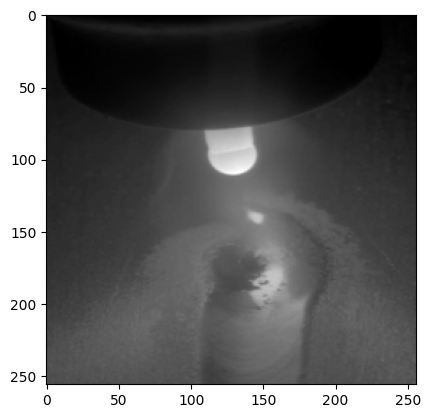

Label : contamination


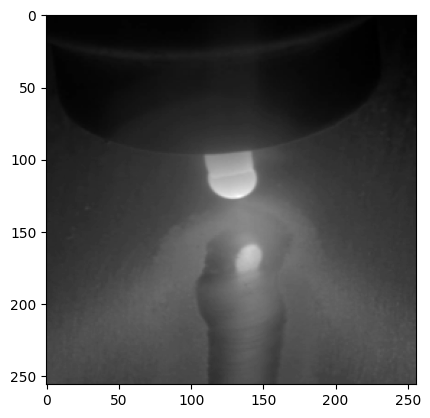

Label : lack of penetration


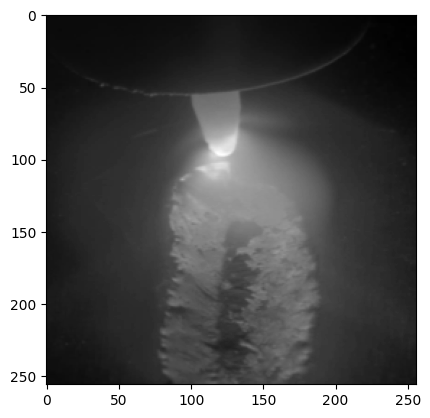

Label : contamination


In [11]:
for _ in range(5):
    rand_img = np.random.randint(low = 0, high = len(X))
    plt.imshow(X[rand_img], cmap='gray')
    plt.show()
    print(f"Label : {label_names[np.argmax(y[rand_img])]}")

In [12]:
total_data = len(X)
X_train, y_train = X[:int(total_data*0.8)], y[:int(total_data*0.8)]
X_test, y_test = X[int(total_data*0.8):], y[int(total_data*0.8):]

In [15]:
def binary_classify(y):
  """
  takes Y_pred as input which has shape of 6x1 representing probability of #dont run
  i.e.     [0,1,2,3,4,5] >= [0,1]
  returns
  """
  y_bin = []
  for j in y:
    if j[0] == 1:
      y_bin.append([1,0]) #good weld
    else:
      y_bin.append([0,1]) #defective
  return tf.convert_to_tensor(y_bin)

In [16]:
y_train_bin = (binary_classify(y_train))
y_test_bin =  binary_classify(y_test)

In [23]:
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

In [24]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(TensorShape([9430, 256, 256]),
 TensorShape([9430, 6]),
 TensorShape([2358, 256, 256]),
 TensorShape([2358, 6]))

In [25]:
X_train = tf.reshape(X_train, shape=(len(X_train), 256, 256, 1))
X_test = tf.reshape(X_test, shape=(len(X_test), 256, 256, 1))

X_train.shape, y_train.shape

(TensorShape([9430, 256, 256, 1]), TensorShape([9430, 6]))

In [37]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 57.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.3/491.3 kB 45.8 MB/s eta 0:00:00


In [38]:
import pennylane as qml

n_qubits = 6
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]


n_layers = 1
weight_shapes = {"weights": (n_layers, n_qubits)}
"""
input x : array 1x6

circuit x -> output : num_qubits = 6 {0,5} <> VQC(measure = 5) + cnot(5,6)

output : array 1x2 /"good weld"

"""

'\ninput x : array 1x6\n\ncircuit x -> output : num_qubits = 7 {0,5} <> VQC(measure = 5) + cnot(5,6)\n\noutput : array 1x2 /"good weld"\n\n'

In [26]:
from tensorflow.keras import layers, regularizers

class MyModel(tf.keras.Model):

    def __init__(self, l2_reg=0.01):
        super().__init__()
        self.conv1 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', input_shape=(image_size[0], image_size[1], 1), kernel_regularizer=regularizers.l2(l2_reg))
        self.pool1 = layers.MaxPooling2D((2, 2))
        self.dropout1 = layers.Dropout(0.2)

        self.conv4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_reg))
        self.pool4 = layers.MaxPooling2D((2, 2))
        self.dropout3 = layers.Dropout(0.2)

        self.conv5 = layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2_reg))
        self.pool5 = layers.MaxPooling2D((2, 2))

        self.flatten = layers.Flatten()

        self.dense1 = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))
        self.dense2 = layers.Dense(12, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))
        self.dense3 = layers.Dense(len(labels), activation='softmax')
        self.q_layer_1 = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)
        self.q_layer_2 = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.dropout1(x)

        x = self.conv4(x)
        x = self.pool4(x)
        x = self.dropout3(x)

        x = self.conv5(x)
        x = self.pool5(x)

        x = self.flatten(x)

        x = self.dense1(x)
        x = self.dense2(x)
        x_1, x_2 = tf.split(x, 2, axis=1)
        x_1 = qlayer_1(x_1)
        x_2 = qlayer_2(x_2)
        x = tf.concat([x_1, x_2], axis=1)
        output = self.dense3(x)

        return output


In [27]:
model = MyModel()

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [28]:
print(f"Train dataset Size : {len(X_train)}\nTest Dataset size : {len(X_test)}")

Train dataset Size : 9430
Test Dataset size : 2358


In [29]:
callback1 = tf.keras.callbacks.ModelCheckpoint(
    filepath='/model',
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,
)

In [32]:
model.fit(x=X_train, y=y_train, epochs=1, validation_data=(X_test, y_test), callbacks=[callback1])

295/295 [==============================] - ETA: 0s - loss: 6.1047 - accuracy: 0.8555
Epoch 1: val_accuracy improved from -inf to 0.18533, saving model to /model
295/295 [==============================] - 905s 3s/step - loss: 6.1047 - accuracy: 0.8555 - val_loss: 8.4444 - val_accuracy: 0.1853


In [33]:
model.load_weights('/model')

In [34]:
predictions = model.predict(X_test)

74/74 [==============================] - 45s 613ms/step


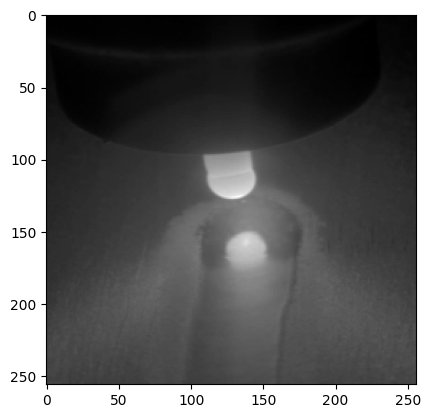

Prediction : lack of penetration
Original : lack of penetration


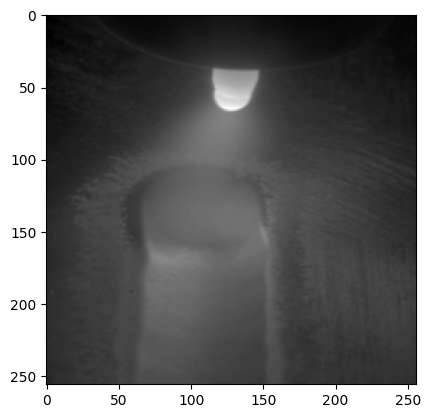

Prediction : lack of penetration
Original : misalignment


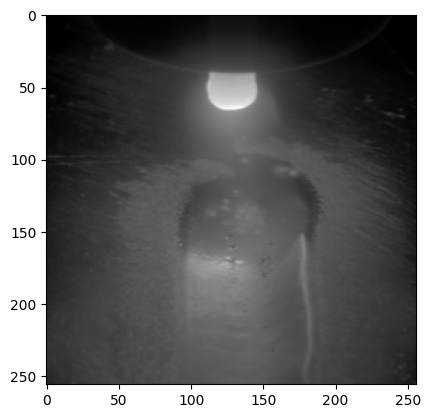

Prediction : lack of penetration
Original : good weld


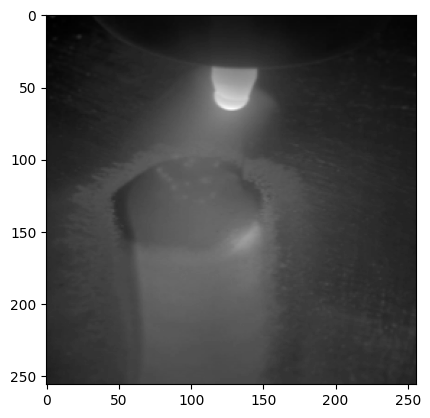

Prediction : lack of penetration
Original : misalignment


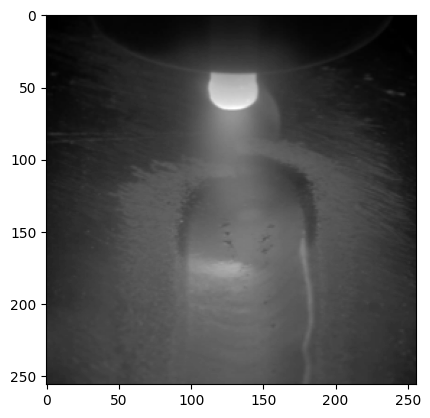

Prediction : lack of penetration
Original : good weld


In [35]:
for _ in range(5):
    rand_img = np.random.randint(low = 0, high = len(X_test))
    plt.imshow(X_test[rand_img].numpy(), cmap='gray')
    plt.show()
    print(f"Prediction : {label_names[np.argmax(predictions[rand_img])]}")
    print(f"Original : {label_names[np.argmax(y_test[rand_img])]}")

In [53]:
# train_metric = model.evaluate(X_train, y_train, verbose=0)
# print(f"Training Loss : {train_metric[0]} , Training Accuracy : {train_metric[1]}")

In [ ]:
test_metric = model.evaluate(X_test, y_test, verbose=0)
print(f"Testing Loss : {test_metric[0]} , Testing Accuracy : {test_metric[1]}")

QUANTUM PART

In [43]:

n_qubits = 6
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

In [40]:
# n_layers = 3
# weight_shapes = {"weights": (n_layers, n_qubits)}
weight_shapes = {"weights": (1, 6)}

In [44]:
q_layer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

In [37]:
y_train_bin = binary_classify(y_train) #dont run
y_test_bin =  binary_classify(y_test)

In [47]:
tf.get_logger().setLevel('ERROR')

  Preparing metadata (setup.py) ... done
  Created wheel for silence-tensorflow: filename=silence_tensorflow-1.2.2-py3-none-any.whl size=5829 sha256=63e72f78ff65f7659fa5526a7d05f8ca4a5d4c899707b4a6bad078ea5a952fdf
  Stored in directory: /root/.cache/pip/wheels/4e/e1/85/e501d21f8d79832caa65e1b779bc17d1847ebc0170f7bc5a80
Successfully built silence-tensorflow


In [49]:
# Freeze the weights of the pre-trained model
model.trainable = False

# Create a new model with the QuantumLayer on top
input_layer = tf.keras.layers.Input(shape=(256, 256, 1))
x = model(input_layer)  # Pass the input through the pre-trained model
x = q_layer(x)  # Apply the quantum layer
output_layer = layers.Dense(2, activation='softmax')(x)  # Add a classical output layer

new_model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

# Compile the new model
new_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the new model
new_model.fit(X_train, y_train_bin, epochs=1, validation_data=(X_test, y_test_bin))


295/295 [==============================] - 1855s 6s/step - loss: 5.8721 - accuracy: 0.8765 - val_loss: 6.4052 - val_accuracy: 0.6455


In [50]:


new_model.save_weights('new_model_weights.h5')


In [ ]:
#
predictions = new_model.predict(X_test)
